# Word2Vec using TF-IDF weights to sum word vectors

## Load data

In [3]:
import pandas as pd
from os import path

importDirectory = "./data/preprocessed-train-test/"

train, test, data, contestTest = map(
    lambda filename: pd.read_csv(path.join(importDirectory, filename)), 
    ["train.csv", "test.csv", "all.csv", "contest-test.csv"])

In [4]:
print("train: {}, test: {}, all: {}, contestTest: {}".format(
    train.shape, test.shape, data.shape, contestTest.shape))

train: (127656, 8), test: (31915, 8), all: (159571, 8), contestTest: (153164, 2)


In [130]:
def cleanSentences(dataset):
    return (dataset.comment_text
    .str.replace("[^A-Za-z\s]", "")
    .str.lower())

In [131]:
%%time
cleanTrain = cleanSentences(train)
cleanTest = cleanSentences(test)

CPU times: user 1.94 s, sys: 0 ns, total: 1.94 s
Wall time: 1.94 s


## TF-IDF

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer().fit(cleanTrain)

In [58]:
word2idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

## Word2Vec

In [59]:
splitTrain = cleanTrain.str.split()
splitTest = cleanTest.str.split()

In [37]:
%%time
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format("./external-models/glove.6B/w2v.glove.6B.300.txt")  

CPU times: user 1min 59s, sys: 844 ms, total: 1min 59s
Wall time: 1min 58s


In [38]:
%%time
vocabulary = set(model.wv.vocab.keys())

CPU times: user 88 ms, sys: 4 ms, total: 92 ms
Wall time: 92.5 ms


In [132]:
%%time
import numpy as np

def wordsToVector(words):
    allowedWords = [word for word in words if word in vocabulary]
    leftWords = allowedWords if allowedWords else ["hello"]
    idfWeights = [word2idf.get(word, 0.) for word in leftWords]
    
    return np.matmul(idfWeights, model.wv[leftWords])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.2 µs


In [133]:
%%time
w2vTrainFeatures = np.array(splitTrain.apply(wordsToVector).tolist())

CPU times: user 1min 28s, sys: 2min 50s, total: 4min 18s
Wall time: 1min 5s


In [134]:
%%time
w2vTestFeatures = np.array(splitTest.apply(wordsToVector).tolist())

CPU times: user 22.2 s, sys: 42.4 s, total: 1min 4s
Wall time: 16.4 s


## Evaluate with logistic regression

           P Neutral  P Toxic
T Neutral      27494     1362
T Toxic         1039     2020


           P Neutral   P Toxic
T Neutral   0.861476  0.042676
T Toxic     0.032555  0.063293


0.627


0.2778


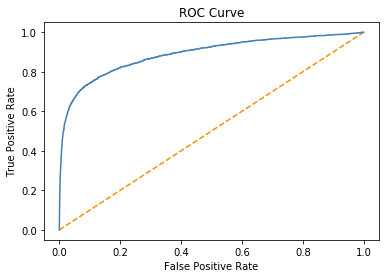

           P Neutral  P Toxic
T Neutral     110201     5220
T Toxic         4057     8178


           P Neutral   P Toxic
T Neutral   0.863265  0.040891
T Toxic     0.031781  0.064063


0.638


0.2599


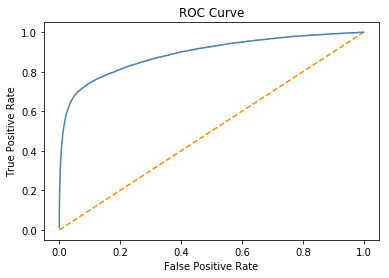

In [135]:
from feature_evaluation_logistic_regression import evaluateFeaturesWithLogisticRegression

evaluateFeaturesWithLogisticRegression(w2vTrainFeatures, w2vTestFeatures, train.toxic, test.toxic)